# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project

Notebook 2: Data Cleaning & EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

In [2]:
# set the display to maximum for easy review of the data

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
scripts = pd.read_csv('../data/scripts_no_title.csv')
scripts.head()

,character,line,episode
0,JERRY,"You know, why we're here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about ""We should go out""? This is what they're talking about...this whole thing, we're all out now, no one is home. Not one person here is home, we're all out! There are people tryin' to find us, they don't know where we are. (imitates one of these people ""tryin' to find us""; pretends his hand is a phone) ""Did you ring?, I can't find him."" (imitates other person on phone) ""Where did he go?"" (the first person again) ""He didn't tell me where he was going"". He must have gone out. You wanna go out: you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...There you're staring around, whatta you do? You go: ""We gotta be getting back"". Once you're out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, it's my feeling, you've gotta go. (Pete's luncheonette. Jerry and George are sitting at a table.)","GOOD NEWS, BAD NEWS"
1,JERRY,"Seems to me, that button is in the worst possible spot. (talking about George's shirt) The second button literally makes or breaks the shirt, look at it: it's too high! It's in no-man's-land, you look like you live with your mother.","GOOD NEWS, BAD NEWS"
2,GEORGE,Are you through? (kind of irritated),"GOOD NEWS, BAD NEWS"
3,JERRY,"You do of course try on, when you buy?","GOOD NEWS, BAD NEWS"
4,GEORGE,"Yes, it was purple, I liked it, I don't actually recall considering the buttons.","GOOD NEWS, BAD NEWS"


In [4]:
scripts.shape

(54211, 3)

Our data has 54,211 rows with 3 features.

### Data Cleaning

Thanks to the scraper built in the previous notebook, the scripts data is fairly clean. Each datapoint consists of three features: the character who was speaking, the corresponding line and the episode name. Upon inital examining, there were no null values or mismatched data types. 

In [5]:
# check null value just in case

scripts.isnull().sum()

character    0
line         0
episode      0
dtype: int64

In [6]:
# check data types

scripts.dtypes

character    object
line         object
episode      object
dtype: object

However, as I further investigated the data, some issues with the data surfaced: 1. there were typos of names in the character columns (i.e: Kramer spelled as "KRAMERT"); 2. inconsistancies in names for each character(i.e: "E", "ElAINE" both refer to as Elaine); 3. some cells in character columns were locations, or actions, not the characters (i.e: "JERRY MOCKING", "INT. MEETING ROOM - DAY"); 4. some lines were spoken by more than one character; 5. there are special characters that are non character names (i.e: "-----" or "======").

In order to reduce the complication of the model, following strategies were used to fix the above issues and clean the data:
1. remove datapoints that have less than  occurance because these data are not likely to provide any valuable inference for the model

In [7]:
occurrence = scripts.value_counts('character', ascending = True)
drop_rows = list(occurrence[occurrence<=10].index)

drop_index=[]
for row in drop_rows:
    ids = list(scripts[scripts['character'] == row].index)
    for i in ids:
        drop_index.append(i)
        
scripts.drop(drop_index, inplace=True)

scripts.reset_index(drop=True, inplace=True)

2. correct typos, redundant character names 

In [8]:
scripts['character'] = ['KRAMER' if i == 'KRAMER,' else i for i in scripts['character']]

In [9]:
scripts['character'] = ['JERRY' if i == 'JERRY,' else i for i in scripts['character']]

In [10]:
scripts['character'] = ['UNCLE LEO' if i == 'LEO' else i for i in scripts['character']]

In [11]:
scripts['character'] = ['JOE DAVOLA' if i == 'JOE DIVOLA' else i for i in scripts['character']]

In [12]:
scripts['character'] = ['WOMAN' if i == 'WOMEN' else i for i in scripts['character']]

3. correct misplaced lines due to the wrong formatting of the data source

In [13]:
for i in list(scripts[scripts.character == 'I'].index):
    scripts.iloc[i-1, 1] = scripts.iloc[i-1, 1] + ' ' + scripts.iloc[i, 0] + ' ' + scripts.iloc[i, 1]
    scripts.drop(i, inplace=True)

4. drop rows where dedicated to two speakers

In [14]:
scripts.drop(list(scripts[scripts['character'] == 'JERRY AND ELAINE'].index), inplace=True)

Moreover, there are 180 aired episodes for <em>Seinfeld</em>, however only 174 unique episodes were collected. This is because: 1. the data didn't include the four clip/highlight episodes - S6E14-E15 "The Highlights of 100", S9E21-E22 "The Clip Show"; 2. the website mislinked two of the regular episodes - S6E1 "The Chaperone" to "The Opposite", S6E7 "The Soup" to "The Soup Nazi", which results in the latter two episodes to have duplicate input in the data. I therefore decide to drop those duplicate rows.

In [15]:
len(scripts.episode.unique())

174

In [16]:
# drop dupliacte "the opposite" script

scripts[(scripts.episode == 'THE OPPOSITE')].loc[24104:24369]
scripts.drop(list(range(24104,24370)), inplace=True)
scripts.reset_index(drop=True, inplace=True)

In [17]:
# drop dupliacte "the soup nazi" script

scripts[scripts.episode == 'THE SOUP NAZI'].loc[25811:26197]
scripts.drop(list(range(25811,26198)), inplace=True)
scripts.reset_index(drop=True, inplace=True)

Our cleaned data now has 50,639 rows and 3 features.

In [18]:
scripts.shape

(50639, 3)

### Feature Engineering for EDA

In [19]:
# create word counts for each line 

def word_count(line):
    
    splited = line.split()
    final = []
    for chunk in splited:
        if '...' in chunk:
            chunk = chunk.split('...')
            for i in chunk:
                final.append(i)
        else:
            final.append(chunk)

    return len(final)

scripts['word_count'] = scripts['line'].map(word_count)

In [21]:
# concatenate the columns 

scripts['char_line'] = (scripts['character'] + ': ' + scripts['line'])

# convert to lowercase

scripts['char_line'] = scripts['char_line'].map(lambda x: x.lower())

### Exploratory Data Analysis

Overview

In [24]:
scripts.groupby('episode')['line'].count().describe()

count    174.000000 
mean     291.028736 
std      99.912472  
min      95.000000  
25%      256.250000 
50%      280.000000 
75%      314.250000 
max      1367.000000
Name: line, dtype: float64

In [75]:
scripts.groupby('episode')['word_count'].sum().describe()

count    174.000000  
mean     3432.327586 
std      1584.192120 
min      1313.000000 
25%      2886.000000 
50%      3172.000000 
75%      3597.000000 
max      21604.000000
Name: word_count, dtype: float64

In [26]:
scripts['word_count'].describe()

count    50639.000000
mean     11.793776   
std      13.870231   
min      1.000000    
25%      4.000000    
50%      8.000000    
75%      15.000000   
max      399.000000  
Name: word_count, dtype: float64

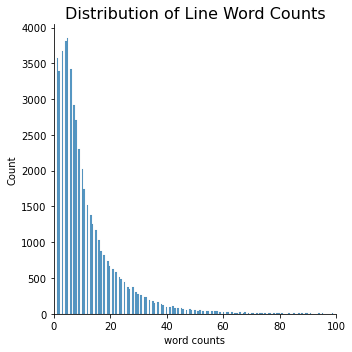

In [159]:
sns.displot(scripts['word_count'], height=5, kind='hist', palette='coolwarm')
plt.title('Distribution of Line Word Counts', fontsize=16)
plt.xlim((0, 100))
plt.xlabel('word counts')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../charts/dist_word_counts.png');

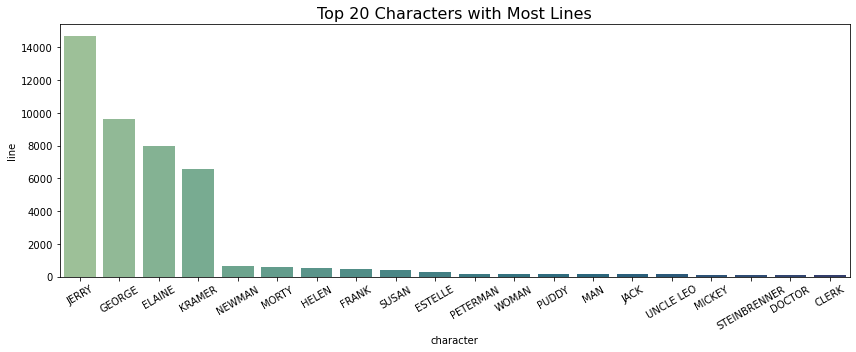

In [160]:
plt.figure(figsize = (12,5))
plt.title('Top 20 Characters with Most Lines', fontsize=16)
sns.barplot(x= scripts.groupby('character')['line'].count().sort_values(ascending = False)[:20].index, 
            y = scripts.groupby('character')['line'].count().sort_values(ascending = False)[:20],
            palette = 'crest')
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/top20_most_lines.png');

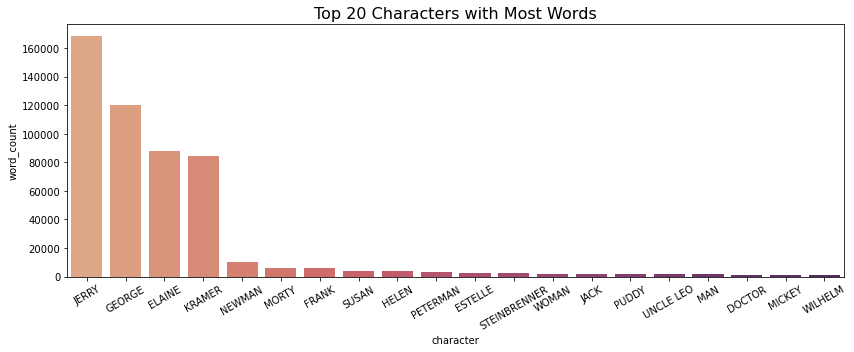

In [161]:
plt.figure(figsize = (12,5))
plt.title('Top 20 Characters with Most Words', fontsize=16)
sns.barplot(x = scripts.groupby('character')['word_count'].sum().sort_values(ascending = False)[:20].index,
            y = scripts.groupby('character')['word_count'].sum().sort_values(ascending = False)[:20],
            palette = 'flare')
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/top20_most_words.png');

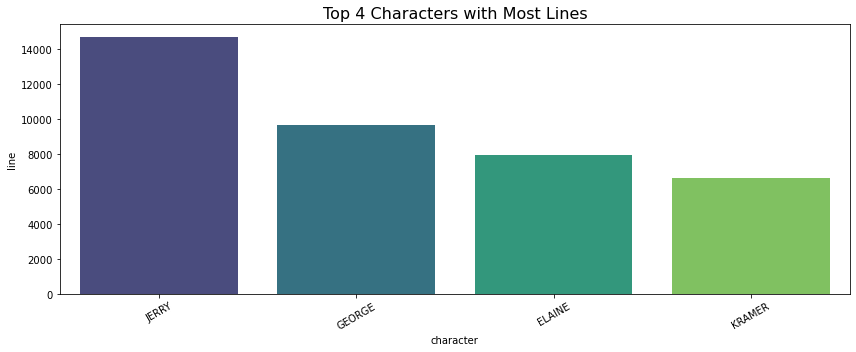

In [162]:
plt.figure(figsize = (12,5))
plt.title('Top 4 Characters with Most Lines', fontsize=16)
sns.barplot(x= scripts.groupby('character')['line'].count().sort_values(ascending = False)[:4].index, 
            y = scripts.groupby('character')['line'].count().sort_values(ascending = False)[:4],
            palette = 'viridis')
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/top4_most_lines.png');

Sentiment Analysis

In [33]:
def sentiment(text):
    sentiment = SentimentIntensityAnalyzer()
    score = sentiment.polarity_scores(text)
    return score['compound']

scripts['sentiment_score'] = scripts['line'].map(sentiment)

In [35]:
def convert_sen(num):
    if num > 0:
        return 'positive'
    elif num == 0:
        return 'neutral'
    else:
        return 'negative'
    
scripts['sentiment'] = scripts['sentiment_score'].map(convert_sen)

In [37]:
char = ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER', 'FRANK', 'MORTY', 'HELEN', 'SUSAN', 'ESTELLE', 'NEWMAN']

for name in char:
    scripts[scripts.character == name].groupby(['character', 'sentiment'])['sentiment_score'].count()

In [113]:
sentiment_counts = scripts[(scripts.character == 'GEORGE') | (scripts.character == 'KRAMER') | (scripts.character == 'ELAINE') | (scripts.character == 'JERRY')].groupby(['character', 'sentiment'])['sentiment_score'].count()

character  sentiment
ELAINE     negative     1417
           neutral      3909
           positive     2627
GEORGE     negative     1797
           neutral      4513
           positive     3324
JERRY      negative     2665
           neutral      7290
           positive     4706
KRAMER     negative     1152
           neutral      2860
           positive     2585
Name: sentiment_score, dtype: int64

In [184]:
sent_by_top4 = pd.DataFrame(sentiment_counts)
sent_by_top4.groupby('character').transform(lambda x: x/x.sum())

sentiment_score
character sentiment                 
ELAINE    negative   0.178172       
          neutral    0.491513       
          positive   0.330316       
GEORGE    negative   0.186527       
          neutral    0.468445       
          positive   0.345028       
JERRY     negative   0.181775       
          neutral    0.497238       
          positive   0.320988       
KRAMER    negative   0.174625       
          neutral    0.433530       
          positive   0.391845

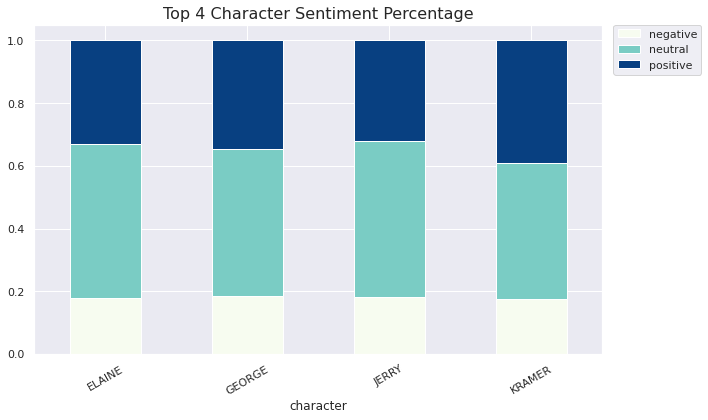

In [218]:
sns.set()
sent_by_top4.groupby('character').transform(lambda x: x/x.sum()).unstack('sentiment').plot.bar(figsize=(10, 6), 
                                                                                               stacked=True, 
                                                                                               colormap='GnBu')
plt.title('Top 4 Character Sentiment Percentage', fontsize=16)                                                                                    
# code to change position of legends from: https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
plt.legend(['negative', 'neutral', 'positive'], bbox_to_anchor=(1.02, 1.0), loc=2, borderaxespad=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../charts/top4_sentiment_percentage.png');

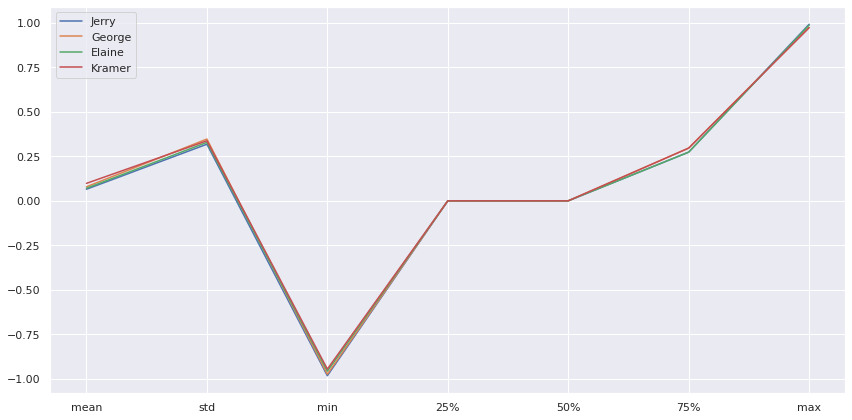

In [219]:
plt.figure(figsize = (12, 6))
plt.plot(scripts[scripts.character == 'JERRY']['sentiment_score'].describe()[1:], label='Jerry')
plt.plot(scripts[scripts.character == 'GEORGE']['sentiment_score'].describe()[1:], label='George')
plt.plot(scripts[scripts.character == 'ELAINE']['sentiment_score'].describe()[1:], label='Elaine')
plt.plot(scripts[scripts.character == 'KRAMER']['sentiment_score'].describe()[1:], label='Kramer')
plt.legend()
plt.tight_layout()
plt.savefig('../charts/top4_sentiment_describe.png');

Content Analysis

Preprocessing to remove all the description text within the parenthethis

In [40]:
def remove_par(text):
    text = re.sub('\((.*?)\)', '', text)
    return text

scripts['line_no_par'] = scripts['line'].map(remove_par)

Most common words by characters without custom stop words

In [41]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

know      1233
don       1107
oh        992 
yeah      982 
just      824 
like      797 
hey       634 
jerry     624 
george    605 
ll        600 
right     585 
kramer    574 
elaine    564 
think     534 
got       528 
did       490 
going     422 
really    420 
want      416 
good      380 
dtype: int64

In [42]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

oh        877
know      687
yeah      637
jerry     557
just      506
don       490
kramer    351
george    349
right     324
like      317
elaine    314
hey       292
think     286
got       281
really    270
did       257
uh        253
ll        243
going     233
mean      208
dtype: int64

In [43]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

know      896
don       669
jerry     628
like      617
yeah      598
oh        595
just      593
right     485
think     426
uh        425
george    421
got       402
hey       376
ll        369
really    318
good      303
kramer    295
gonna     290
tell      287
going     286
dtype: int64

In [44]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

yeah      985
jerry     718
oh        676
know      552
hey       551
kramer    409
got       408
don       396
uh        358
right     342
ll        325
just      314
george    313
like      301
look      279
elaine    261
gonna     249
going     206
come      205
want      175
dtype: int64

Most common bigram

In [45]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

don know           299
don want           106
don think          88 
oh yeah            80 
ve got             68 
oh god             64 
wait second        62 
ll tell            53 
oh hi              50 
yeah yeah          46 
jerry apartment    44 
uncle leo          43 
yeah right         42 
hey hey            41 
ve seen            37 
kramer enters      36 
didn know          36 
don understand     34 
coffee shop        32 
did say            30 
dtype: int64

In [46]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

don know           130
oh god             79 
ha ha              63 
oh yeah            59 
yeah yeah          58 
ve got             50 
don think          44 
don want           44 
mr peterman        37 
mr pitt            34 
oh come            32 
jerry apartment    31 
oh oh              31 
yeah right         29 
jerry jerry        28 
oh hi              26 
know just          26 
ll just            25 
did say            23 
kramer enters      23 
dtype: int64

In [47]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))


X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

don know           159
yeah yeah          62 
don think          56 
hey hey            52 
oh god             51 
ha ha              45 
oh yeah            44 
don want           43 
wait minute        42 
ll tell            40 
jerry apartment    38 
right right        34 
ve got             34 
don like           30 
let just           29 
jerry george       28 
new scene          28 
yeah right         28 
kramer enters      27 
did say            26 
dtype: int64

In [48]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

oh yeah            137
yeah yeah          111
don know           63 
hey hey            46 
hey jerry          40 
don want           39 
ve got             38 
oh hey             34 
wait wait          33 
ll tell            29 
hey buddy          27 
oh come            25 
kramer leaves      25 
jerry george       25 
alright ll         24 
jerry apartment    24 
uh uh              23 
come jerry         22 
new scene          22 
yeah know          22 
dtype: int64

Most common trigrams

In [49]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

hello oh hi                 21
wait second wait            12
new scene jerry             12
second wait second          12
don know just               11
hey hey hey                 10
black white dress           8 
oh don know                 8 
phone rings jerry           8 
hi jerry seinfeld           8 
wait wait wait              8 
let ask question            8 
oh yeah right               7 
don know got                7 
sagman bennet robbins       7 
ll tell ya                  7 
know don know               6 
bennet robbins oppenheim    6 
jerry hangs phone           6 
door opens kramer           6 
dtype: int64

In [50]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

ha ha ha               33
oh god oh              8 
oh oh oh               8 
don know don           8 
know don know          7 
new scene jerry        7 
oh yeah right          5 
wait minute kramer     5 
wait minute wait       5 
minute wait minute     5 
god oh god             5 
jerry opens door       5 
oh don know            5 
slams door shut        5 
don know just          5 
kramer elaine walks    5 
guess ll just          5 
yeah yeah uh           5 
don just shut          5 
looking shop window    4 
dtype: int64

In [51]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))


X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

hey hey hey               17
ha ha ha                  14
new scene jerry           14
wait minute wait          11
minute wait minute        10
yeah yeah yeah            10
met antique store         8 
la la la                  8 
ho ho ho                  7 
new scene kramer          6 
george george costanza    5 
kramer sit couch          5 
need talk jerry           5 
door opens kramer         5 
jerry apartment jerry     5 
oh oh oh                  5 
oh yeah sure              5 
opens kramer enters       5 
don know don              5 
uh don know               5 
dtype: int64

In [52]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

oh yeah yeah             31
hey hey hey              18
wait wait wait           17
yeah yeah yeah           14
kramer heads door        11
ho ho ho                 9 
oh come jerry            8 
kramer holds hand        8 
new scene jerry          8 
coffee table book        7 
oh yeah got              7 
kramer opens door        6 
little jerry seinfeld    6 
ll tell ll               5 
alright look jerry       5 
yeah yeah got            5 
alright alright ll       5 
kramer leaves closes     5 
leaves closes door       5 
yeah elaine enters       5 
dtype: int64

With custom stop words

In [53]:
stop_words_uni = [x for x in ENGLISH_STOP_WORDS]
additional = ['yeah', 'oh', 'hey', 'll', 'jerry', 'kramer', 'george', 'elaine', 'did', 've']
for word in additional:
    stop_words_uni.append(word)

In [54]:
stop_words_bi = [x for x in ENGLISH_STOP_WORDS if x != 'get' and x != 'out']
additional = ['yeah', 'oh', 'hey', 'll', 'jerry', 'kramer', 'george', 'elaine', 'did', 've']
for word in additional:
    stop_words_bi.append(word)

In [55]:
stop_words_tri = [x for x in ENGLISH_STOP_WORDS if x != 'get' and x != 'out' and x != 'a']
additional = ['yeah', 'oh', 'hey', 'll', 'jerry', 'kramer', 'george', 'elaine', 'did', 've']
for word in additional:
    stop_words_tri.append(word)

In [56]:
# everybody = scripts['line_no_par'].copy()

# counter = 0
# for line in everybody:
#     if 'get out' in line:
#         counter += 1
        
# counter

In [57]:
everybody = scripts['line_no_par'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000, 
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(everybody)

everybody_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

everybody_stop.sum().sort_values(ascending = False).head(25)

don know          783
don want          280
don think         280
get out           248
ha ha             208
don like          124
new scene         114
don understand    113
right right       111
wait minute       107
gonna get         107
yes yes           106
didn know         103
coffee shop       100
wait second       100
know just         98 
gotta get         98 
look like         97 
uh huh            89 
know don          88 
don worry         86 
looks like        86 
don get           85 
let just          84 
new york          84 
dtype: int64

In [58]:
everybody = scripts['line_no_par'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000, 
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(everybody)

everybody_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

everybody_stop.sum().sort_values(ascending = False).head(25)

ha ha ha               98
wait wait wait         30
new scene apartment    28
don know don           25
wait minute wait       24
don know just          23
minute wait minute     22
know don know          22
ho ho ho               19
wait second wait       18
door opens enters      17
let ask question       17
second wait second     16
del boca vista         16
coffee table book      15
get hell out           14
don know gonna         14
don know got           14
get out get            13
out get out            13
don want get           13
don know maybe         13
la la la               13
don think gonna        12
yada yada yada         12
dtype: int64

In [59]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

know      1233
don       1107
just      824 
like      797 
right     585 
think     534 
got       528 
going     422 
really    420 
want      416 
good      380 
gonna     369 
come      348 
look      333 
uh        308 
guy       307 
didn      301 
little    278 
tell      268 
thing     260 
dtype: int64

In [60]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

know      687
just      506
don       490
right     324
like      317
think     286
got       281
really    270
uh        253
going     233
mean      208
look      194
gonna     190
good      182
hi        173
come      172
want      171
okay      162
didn      158
tell      149
dtype: int64

In [61]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

know      896
don       669
like      617
just      593
right     485
think     426
uh        425
got       402
really    318
good      303
gonna     290
tell      287
going     286
yes       234
look      219
didn      213
let       213
want      212
say       198
time      197
dtype: int64

In [62]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

know       552
got        408
don        396
uh         358
right      342
just       314
like       301
look       279
gonna      249
going      206
come       205
want       175
think      169
alright    159
good       157
huh        152
let        150
newman     138
man        137
gotta      132
dtype: int64

In [63]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

don know          299
don want          106
don think         88 
get out           73 
wait second       62 
uncle leo         43 
didn know         36 
going out         34 
don understand    34 
coffee shop       32 
gotta get         31 
don care          30 
know just         30 
don get           30 
uh huh            30 
don wanna         28 
new scene         27 
look like         26 
right right       26 
gonna get         26 
dtype: int64

In [64]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

don know          130
ha ha             63 
don want          44 
don think         44 
get out           38 
mr peterman       37 
mr pitt           34 
know just         26 
wait minute       22 
didn know         21 
don just          19 
yes yes           18 
don understand    18 
going out         17 
don like          17 
coffee shop       17 
uh huh            15 
uh uh             15 
know really       15 
know don          15 
dtype: int64

In [65]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

don know          160
don think         56 
get out           54 
ha ha             45 
don want          43 
wait minute       42 
right right       34 
don like          30 
let just          29 
gonna get         29 
new scene         28 
yes yes           25 
look like         25 
gotta get         25 
don understand    23 
don worry         23 
don get           23 
ho ho             23 
didn know         23 
know like         21 
dtype: int64

In [66]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

don know        63
don want        39
wait wait       33
uh uh           30
don think       22
new scene       22
yes yes         21
gonna get       21
get out         20
right right     18
coffee table    18
new york        16
let get         15
ho ho           15
know gonna      15
don like        15
gotta get       15
got big         14
know got        14
check out       14
dtype: int64

In [67]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

second wait second          12
wait second wait            12
don know just               11
black white dress           8 
wait wait wait              8 
let ask question            8 
don wanna get               7 
door opens enters           7 
new scene apartment         7 
don know got                7 
sagman bennet robbins       7 
ha ha ha                    6 
know don know               6 
bennet robbins oppenheim    6 
don think gonna             6 
robbins oppenheim taft      6 
don know maybe              6 
don know getting            6 
don want talk               5 
enters carrying small       5 
dtype: int64

In [68]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

ha ha ha                      33
don know don                  8 
know don know                 7 
slams door shut               5 
wait minute wait              5 
wait minute know              5 
minute wait minute            5 
don know just                 5 
don just shut                 5 
cut stupid thing              4 
crock worse removes           4 
huh christie comes            4 
opens door reveal             4 
okay good good                4 
hold trailing end             4 
get bike wall                 4 
didn things literally         4 
good comes street             4 
notices smiles flirtatious    4 
gestures susan having         4 
dtype: int64

In [69]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

ha ha ha                 14
wait minute wait         11
minute wait minute       10
new scene apartment      9 
la la la                 8 
met antique store        8 
ho ho ho                 7 
door opens enters        6 
gonna get out            5 
get hell out             5 
don know don             5 
uh don know              5 
let ask question         5 
nice people gonna        4 
issue long time          4 
just sits tv             4 
just stay calm           4 
just told contretemps    4 
ken carrie look          4 
ken costanza think       4 
dtype: int64

In [70]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

wait wait wait           17
ho ho ho                 9 
coffee table book        7 
new scene apartment      6 
alright look gotta       5 
leaves closes door       5 
leans out window         5 
out mouthful taken       4 
option shuts fridge      4 
coats fastened collar    4 
clumsily out ringing     4 
head steps away          4 
going ride opens         4 
out ringing bell         4 
out shock lets           4 
out window parked        4 
outside world trade      4 
pain come pleasure       4 
closing door bang        4 
opens pokes head         4 
dtype: int64

For Fun

In [82]:
soup_nazi = scripts[scripts['character'] == 'SOUP NAZI'].copy()

cvec = CountVectorizer(stop_words=stop_words_tri,
                       min_df=2,
                       max_features=2000, 
                       ngram_range=(1, 3))

X_stop = cvec.fit_transform(soup_nazi['line_no_par'])

soup_nazi_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

soup_nazi_stop.sum().sort_values(ascending = False).head(15)

soup           6
bread          3
good           3
want           3
recipe         2
come           2
get            2
know           2
mushroom       2
yes            2
recipe wild    2
year           2
right          2
want bread     2
wild           2
dtype: int64

In [83]:
joe_davola = scripts[scripts['character'] == 'JOE DAVOLA'].copy()

cvec = CountVectorizer(stop_words=stop_words_tri,
                       min_df=2,
                       max_features=2000, 
                       ngram_range=(1, 3))

X_stop = cvec.fit_transform(joe_davola['line_no_par'])

soup_joe_davola = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

soup_joe_davola.sum().sort_values(ascending = False).head(15)

know          7
like          4
nedda         3
divola        3
don           3
get           3
want          3
clown         3
pagliacci     3
make          2
looking       2
out           2
just          2
joe divola    2
joe           2
dtype: int64

### Visualization - Word Cloud 

In [84]:
def plot_cloud(wordcloud, filename):
    plt.figure(figsize=(15, 12))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig('../charts/'+filename+'_wordcloud.png');

In [85]:
def combine_lines(df, column):
    combined = ''
    for line in df[column]:
        combined += line
    return combined

In [86]:
mask = np.array(Image.open('../img/wordcloud_mask.png'))

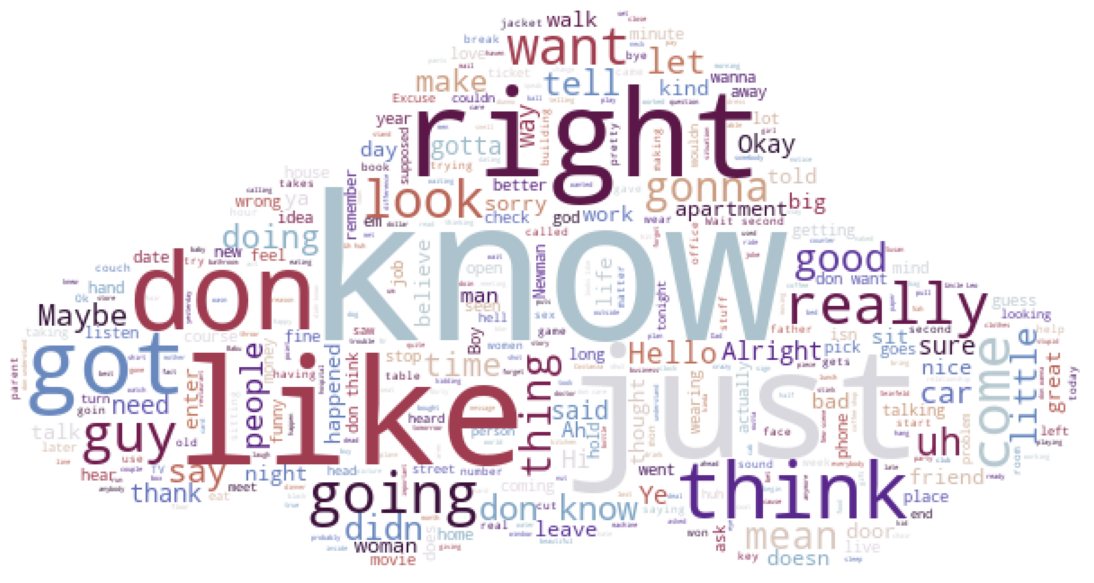

In [88]:
jerry_text = combine_lines(jerry, 'line_no_par')

wordcloud_jerry = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='white', 
                      colormap='twilight', 
                      collocations=True, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(jerry_text)

plot_cloud(wordcloud_jerry, 'jerry')

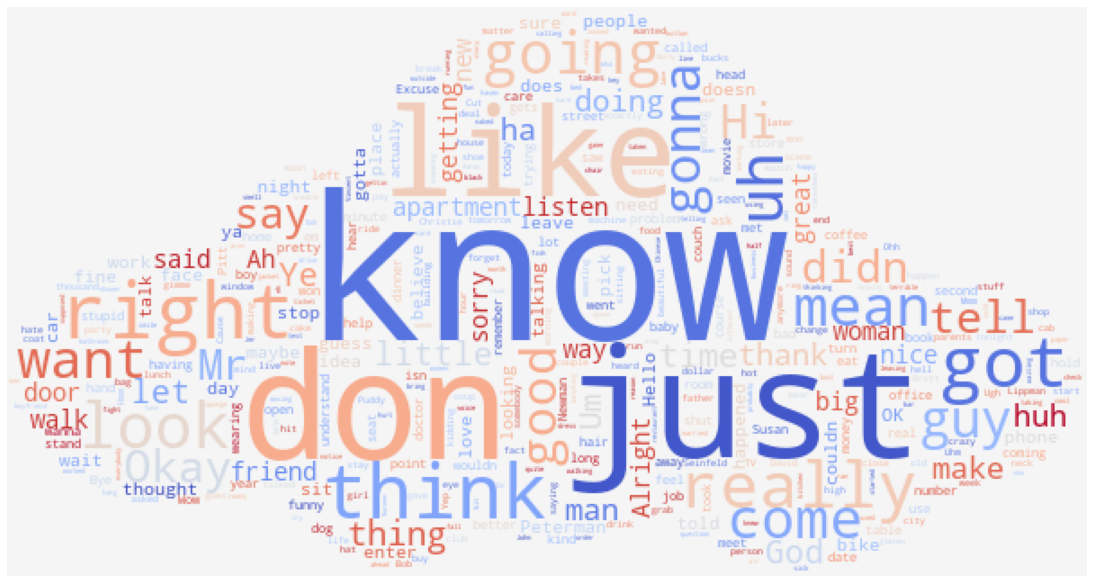

In [89]:
elaine_text = combine_lines(elaine, 'line_no_par')

wordcloud_elaine = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='whitesmoke', 
                      colormap='coolwarm', 
                      collocations=False, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(elaine_text)

plot_cloud(wordcloud_elaine, 'elaine')

In [ ]:
george_text = combine_lines(george, 'line_no_par')

wordcloud_george = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='snow', 
                      colormap='Wistia', 
                      collocations=False, 
                      stopwords = stop_words,
                      mask=mask).generate(george_text)

plot_cloud(wordcloud_george, 'george')

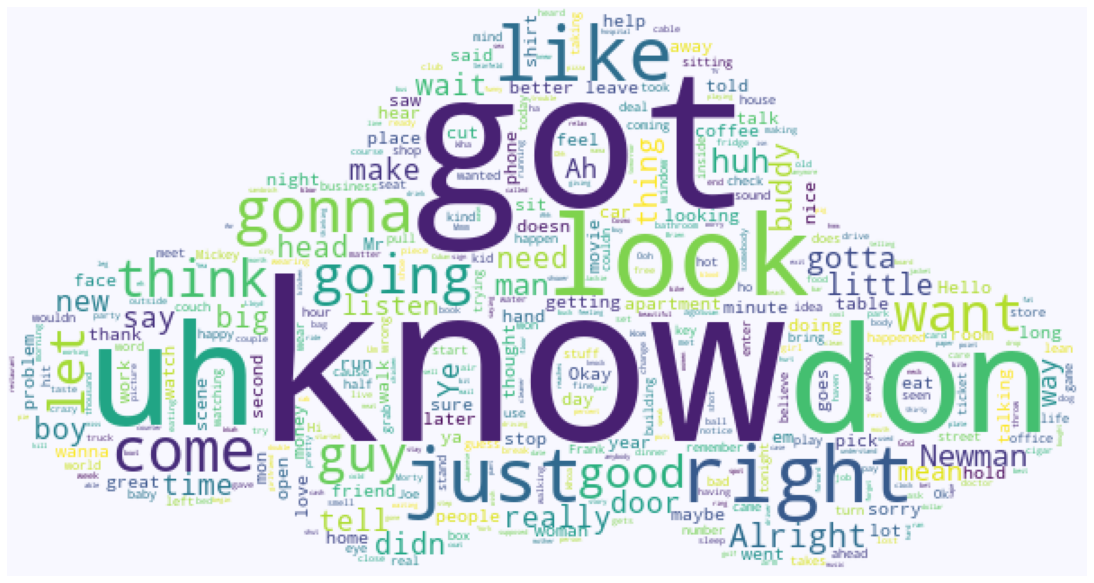

In [90]:
kramer_text = combine_lines(kramer, 'line_no_par')

wordcloud_kramer = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='ghostwhite', 
                      colormap='viridis', 
                      collocations=False, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(kramer_text)

plot_cloud(wordcloud_kramer, 'kramer')

Do multiclass classfication to predict who says what line and try to find a tagline/topwords and coef

### Finalizing Data

In [ ]:
df = pd.DataFrame(data=scripts['char_line'])
df.head()

In [42]:
df.to_csv('../data/for_train.csv')

texts='\n'.join(df['char_line'])

with open('../data/for_train.txt', 'w') as f:
    f.write(texts)